# Introduction to Monte Carlo Integration



Import useful packages

In [15]:
import numpy as np
import matplotlib.pyplot as plt

## First task: compute pi stochastically

In [275]:
#As an example, this function generates 10 pairs of random numbers between 0 and 1.
Npoints = 10
data = np.random.rand(Npoints,2)

#Rescale them to be between -1 and 1
data = 2*data-1

print(data)

[[ 0.40994733 -0.48751238]
 [-0.57828222 -0.4516534 ]
 [-0.3733558  -0.75182414]
 [-0.14947068  0.84326452]
 [ 0.85181231  0.55438193]
 [ 0.63547857  0.07300306]
 [ 0.82216194  0.39433887]
 [ 0.1641352  -0.82558178]
 [ 0.09113062  0.28089475]
 [ 0.62131099 -0.13744862]]


Lets plot the data together with a circle

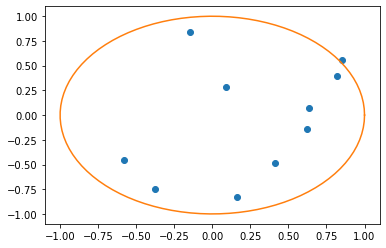

In [276]:
fig, ax = plt.subplots()

#plot the data
ax.plot(data[:,0], data[:,1], 'o' )

#plot a circle
phase = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(phase), np.sin(phase))

An estimate of the area of the circle can be derived from the points inside versus points outside

In [277]:
#Compute the distance to the center
mod = np.linalg.norm(data, axis=1)
print("Distance to the center", mod)

#Which points are inside the circle?
inside = 1.0*(mod < 1)
print("Inside?", inside)

#Compute estimate of area
# The area is ratio of points inside times area of the square
total_area = 2**2 
inside_area = np.sum(inside)/len(inside) * total_area
print("Area inside the curve is", inside_area, "Analytical result is ", np.pi)

Distance to the center [0.63696557 0.73375822 0.83942485 0.8564091  1.01632846 0.63965808
 0.91184067 0.84173965 0.29530772 0.63633283]
Inside? [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
Area inside the curve is 3.6 Analytical result is  3.141592653589793


### Exercises 1:
1. Compute pi more precisely, and plot the result as a function of the number of used samples. 
2. Compute an estimate of the statictical uncertainty. The statistical uncertainty can be derived from the standard deviation between the measurements of "0" or "1" (outside or inside).
$$ {\rm error}  = \frac{\rm std(data)}{\sqrt{N_{\rm samples}}}$$
Add errors to the previous plot.
3. Compute the volume of a sphere in a similar way with statistical uncertainties.



## Task 2: A Gaussian integral with the metropolis algorithm (0-D lattice scalar theory) 

Let us consider a probability distribution of the form $p = \frac{1}{Z} e^{-x^2}$. This can be interpreted as a trivial 0-D scalar QFT. 

The goal is to compute "correlation functions", that is, observables of the form
$$C = \langle x^n \rangle  = \frac{1}{Z}\int dx \, x^n \,  e^{-x^2},$$
where we can consider $O=x^n$ to be our operator. 

Note that we need $n={\rm even}$ to have nonzero values, because the theory has a $x \to -x$ symmetry.

We would like to this using the Metropolis-Hastings algorithm


In [278]:
#Auxiliary functions to make a metropolis step

def action(x):
    return x**2

def next_porposal(x):    
    delta = 2*np.random.rand() - 1 #random number between -1 and 1 
    width = 0.7 # This is a tunable "hyperparameter"
    return x + width*delta


def metropolis_step(x_in):
    
    initial_action = action(x_in)
    
    x_proposal = next_porposal(x_in)
    
    proposal_action = action(x_proposal)
    
    accept_probability = np.random.rand()

    deltaS = proposal_action - initial_action
    
    if( np.exp(-deltaS) > accept_probability ):
        x_next = x_proposal
        accept = 1
    else:
        x_next = x_in
        accept = 0
        
    return x_next, accept #returns new sample and if it was accepted or not

Let us build a Markov Chain by iterating Metropolis Steps

In [344]:
#Build a Markov Chain

samples = [10.0]
acceptance = []

Nsteps = 1000

for i in range(Nsteps-1): 
    
    last_x = samples[-1]
    xnew, accept = metropolis_step(last_x)
    samples.append(xnew)
    acceptance.append(accept)

acceptance = np.array(acceptance)
samples = np.array(samples)


print("Acceptance is", np.mean(acceptance)*100 , "%" )
print("Typically the optimal choice is around 60-70%")

Acceptance is 78.17817817817819 %
Typically the optimal choice is around 60-70%


Let us plot the Monte Carlo History. Depending of the initial guess, the chain amy require a number of steps to "equilibrate". In lattice QCD we call this "Thermalization". 

Text(0.5, 0, 'Monte Carlo Step')

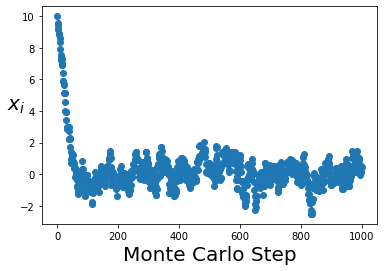

In [293]:
fig, ax = plt.subplots()

ax.plot(range(Nsteps), samples, 'o' )
ax.set_ylabel("$x_i$", fontsize=20,rotation=0)
ax.set_xlabel("Monte Carlo Step", fontsize=20,rotation=0)


The thermalization steps should be removed. If not, our observables will be biased. 

If we truncate the first few samples, the Monte Carlo history should lood like random numbers centered around zero.

Text(0.5, 0, 'Monte Carlo Step')

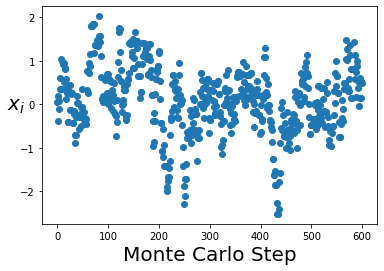

In [324]:
Ntherm = 400 #Remove the first Ntherm samples from the MCMC
samples_thermalized = samples[Ntherm:]
fig, ax = plt.subplots()

ax.plot(range(len(samples_thermalized)), samples_thermalized, 'o' )
ax.set_ylabel("$x_i$", fontsize=20,rotation=0)
ax.set_xlabel("Monte Carlo Step", fontsize=20,rotation=0)

If we plot the samples like a histogram, it should start looking like a Gaussian.

(array([  7.,  14.,  14.,  40., 117., 138., 135.,  77.,  44.,  14.]),
 array([-2.51697445, -2.06298203, -1.60898961, -1.1549972 , -0.70100478,
        -0.24701236,  0.20698006,  0.66097247,  1.11496489,  1.56895731,
         2.02294973]),
 <BarContainer object of 10 artists>)

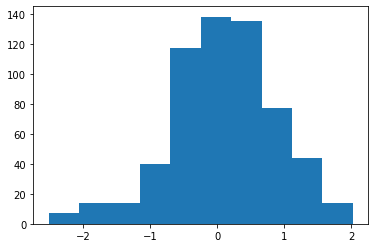

In [345]:
plt.hist(samples_thermalized)

### Exercises 2.1:
1. Play with the "hyperparameter" in the metropolis algorith, i.e. the "width". How does the acceptance dependend on the width?
2. Play with the initial guess in the Markov Chain. What is a better choice?  


Now it's time to evaluate our observables, for instance: $\langle x \rangle$ and $\langle x^2 \rangle$. 

We know the analytical results, so that we can compare: $$ \langle x \rangle =0, \quad \langle x^2 \rangle = 1/2 .$$

In [326]:
observable1 = samples_thermalized
print("Our Monte Carlo estimate of <x> = ",np.mean(observable1))
observable2 = samples_thermalized**2
print("Our Monte Carlo estimate of <x^2> = ",np.mean(observable2))

Our Monte Carlo estimate of <x> =  0.09452813178048465
Our Monte Carlo estimate of <x^2> =  0.6188105654543339


However, estimates without uncertainties are meaningless! Let us compute the uncertainty. 

First, the naive uncertainty, like in the first exercise:

In [334]:
error_naive_obs1 = np.std(observable1)/np.sqrt(len(observable1))
error_naive_obs2 = np.std(observable2)/np.sqrt(len(observable2))


print("<x> = ", np.mean(observable1), "+/-", error_naive_obs1, "True answer is <x>=0", "Sigmas away:", np.mean(observable1)/error_naive_obs1 )
print("<x^2> = ", np.mean(observable2), "+/-", error_naive_obs2, "True answer is <x^2>=0.5", "Sigmas away:", (np.mean(observable2)-1/2)/error_naive_obs2  )

<x> =  0.09452813178048465 +/- 0.031881943629491004 True answer is <x>=0 Sigmas away: 2.9649425668341474
<x^2> =  0.6188105654543339 +/- 0.039245604025469075 True answer is <x^2>=0.5 Sigmas away: 3.0273598382440445


Depending on the choices of the Metropolis hyperparameter "width", the true answer may be many sigmas away very far from the Monte Carlo estimate. This is due to the so-called "Autocorrelation".

In every Markov Chain, each new proposal depends on the previous one. Thus some "memory" of the previous sample is retained. In other words, two consecutive samples are not fully independent. In order to account for autocorrelation, we must perform several steps before saving the samples.

Alternatively, we can measure every "Nmeas" samples.

In [346]:
Nmeas = 20
spaced_observable1 = observable1[::Nmeas]
spaced_observable2 = observable2[::Nmeas]

error_spaced_obs1 = np.std(spaced_observable1)/np.sqrt(len(spaced_observable1))
error_spaced_obs2 = np.std(spaced_observable2)/np.sqrt(len(spaced_observable2))


print("<x> = ", np.mean(spaced_observable1), "+/-", error_spaced_obs1, "True answer is <x>=0", "Sigmas away:", np.mean(spaced_observable1)/error_spaced_obs1 )
print("<x^2> = ", np.mean(spaced_observable2), "+/-", error_spaced_obs2, "True answer is <x^2>=0.5", "Sigmas away:", (np.mean(spaced_observable2)-1/2)/error_spaced_obs2  )


<x> =  0.12064636904585507 +/- 0.11637859077505183 True answer is <x>=0 Sigmas away: 1.0366715066953545
<x^2> =  0.42087483808755805 +/- 0.0996741921613989 True answer is <x^2>=0.5 Sigmas away: -0.7938380055723689


There are other (better) ways of deaaling with autocorrelation, but this is the simplest: "Make sure your measurements have many Metropolis steps in between". 

Another simple way of dealing with autocorrelation is the so-called binning procedure. For this, you average $N_{\rm bin}$ measurements together, and then treat the binned observables as independent.

In [343]:
Nbin = 40
assert len(observable1)%Nbin==0, "Length of observable array is not divisible by Nbin"

binned_observable1 =  observable1.reshape(int(len(observable1)/Nbin), Nbin  )
binned_observable1 = np.mean(binned_observable1, axis=1)
binned_observable2 =  observable2.reshape(int(len(observable2)/Nbin), Nbin  )
binned_observable2 = np.mean(binned_observable2, axis=1)

error_binned_obs1 = np.std(binned_observable1)/np.sqrt(len(binned_observable1))
error_binned_obs2 = np.std(binned_observable2)/np.sqrt(len(binned_observable2))




print("Nbin=", Nbin)
print("<x> = ", np.mean(binned_observable1), "+/-", error_binned_obs1, "True answer is <x>=0", "Sigmas away:", np.mean(binned_observable1)/error_binned_obs1 )
print("<x^2> = ", np.mean(binned_observable2), "+/-", error_binned_obs2, "True answer is <x^2>=1/2", "Sigmas away:", (np.mean(binned_observable2)-1/2)/error_binned_obs2 )





Nbin= 40
<x> =  0.09452813178048461 +/- 0.12284180776720934 True answer is <x>=0 Sigmas away: 0.7695110768771786
<x^2> =  0.6188105654543337 +/- 0.10917998633097532 True answer is <x^2>=1/2 Sigmas away: 1.0882082829188453


### Exercises 2.2:
1. Plot the error of some observables as a function of $N_{\rm bin}$. The optimal choice should be in the region where there is a "plateau". That is, when increasing $N_{\rm bin}$ does not lead to an increase in the error. 



### Exercises 2.3:
1. Integrate another distribution, for instance:
$$ p = \frac{1}{Z}e^{-S(x)}, \quad S(x) = x^2 + x^4 $$
You could see this as an interacting $\phi^4$ theory. Without the quartic term is like a "free theory".
2. Generalize procedure to an action that depends on two variables:  
$$S[x_1,x_2] = x_1^2 + x_2^2 + x_1^2 x_2^2$$
and compute some observables, e.g. $\langle x_1^n x_2^m \rangle$
You could see this second example as a 1D lattice scalar theory with two lattice points!

In [347]:
#Here's some help for exercise 2

def action(x):
    assert len(x)==2
    return x[0]**2 + x[1]**2 + (x[0]*x[1])**2

def next_porposal(x):    
    delta = 2*np.random.rand(2) - 1 #two random numbers between -1 and 1 
    width = 0.7
    return x + width*delta
